In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from seldonian import *
import numpy as np
from bounds import *
from objectives import *
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from scipy.stats import cumfreq

import pandas as pd
from tempeh.configurations import datasets

from IPython.display import display, HTML, Markdown

from sklearn import preprocessing

%matplotlib inline


In [3]:
dataset = datasets['lawschool_passbar']()

# Load data
X_train, X_test = dataset.get_X(format=pd.DataFrame)
y_train, y_test = dataset.get_y(format=pd.Series)
A_train, A_test = dataset.get_sensitive_features(name='race', format=pd.Series)

# Combine all training data into a single data frame and glance at a few rows
all_train = pd.concat([X_train, y_train, A_train], axis=1)

display(all_train)

,lsat,ugpa,pass_bar,race
0,38.0,3.1,1,white
1,45.0,2.6,1,white
2,36.0,3.6,1,white
3,37.0,3.5,1,white
4,47.0,3.3,1,white
...,...,...,...,...
13703,36.0,3.3,1,white
13704,34.0,3.5,1,white
13705,37.0,3.5,1,white
13706,40.0,3.3,1,white


In [4]:
def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 2

    limits = (min(data), max(data))
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = (limits[0] - s, limits[1] + s)

    for a in np.unique(A):
        subset = data[A == a]

        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)

    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _, v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _, v in cdfs.items()]

    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins == v.cumcount.size for _, v in cdfs.items()])

    xs = lower_limits[0] + np.linspace(0, bin_sizes[0] * num_bins, num_bins)

    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i] / len(data[A == k]) for k, v in cdfs.items()], 0, 1)
        disparities[i] = max(cdf_values) - min(cdf_values)

    return xs, cdfs, disparities


def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)

    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount / len(data[A == k]), label=k)

    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()

    xs_line = [xs[d_idx], xs[d_idx]]
    counts = [v.cumcount[d_idx] / len(data[A == k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]

    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")

    plt.xlabel(data.name)
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()

,count,pass_bar_rate
race,,
black,880,0.780682
white,12828,0.968428


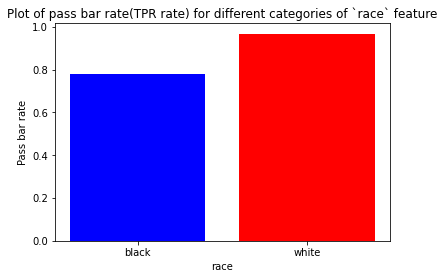

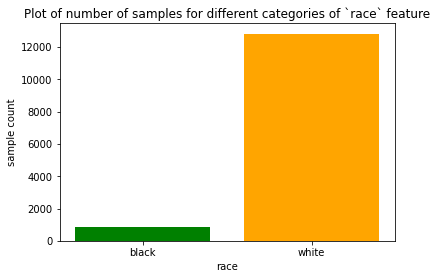

In [5]:
all_train_grouped = all_train.groupby('race')

counts_by_race = all_train_grouped[['lsat']].count().rename(
    columns={'lsat': 'count'})

rates_by_race = all_train_grouped[['pass_bar']].mean().rename(
    columns={'pass_bar': 'pass_bar_rate'})

summary_by_race = pd.concat([counts_by_race, rates_by_race], axis=1)
display(summary_by_race)
plt.bar(summary_by_race.index, summary_by_race['pass_bar_rate'], color=['blue', 'red', 'green', 'black', 'cyan'])
plt.xlabel('race')
plt.ylabel('Pass bar rate')
plt.title('Plot of pass bar rate(TPR rate) for different categories of `race` feature')
plt.show()
plt.bar(summary_by_race.index, summary_by_race['count'], color=['green', 'orange'])
plt.xlabel('race')
plt.ylabel('sample count')
plt.title('Plot of number of samples for different categories of `race` feature')
plt.show()

# plot statistics from the dataset

In [6]:
# Load data
X_train, X_test = dataset.get_X(format=pd.DataFrame)
y_train, y_test = dataset.get_y(format=pd.Series)
A_train, A_test = dataset.get_sensitive_features(name='race', format=pd.Series)

# Combine all training data into a single data frame and glance at a few rows
all_train_raw = pd.concat([X_train, A_train, y_train], axis=1)
all_test_raw = pd.concat([X_test, A_test, y_test], axis=1)

all_data = pd.concat([all_train_raw, all_test_raw], axis=0)

X = all_data[['lsat', 'ugpa', 'race']]
y = all_data[['pass_bar']]
le = preprocessing.LabelEncoder()
X.loc[:,'race'] = le.fit_transform(X['race'])
scaler = preprocessing.StandardScaler()
X.loc[:,['lsat', 'ugpa']] = scaler.fit_transform(X[['lsat', 'ugpa']])
A = X['race']
A_idx = 'race'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
all_train_grouped = all_data.groupby('race')

counts_by_race = all_train_grouped[['lsat']].count().rename(
    columns={'lsat': 'count'})

quartiles_by_race = all_train_grouped[['lsat', 'ugpa']].quantile([.25, .50, .75]).rename(
    index={0.25: "25%", 0.5: "50%", 0.75: "75%"}, level=1).unstack()

rates_by_race = all_train_grouped[['pass_bar']].mean().rename(
    columns={'pass_bar': 'pass_bar_rate'})

summary_by_race = pd.concat([counts_by_race, quartiles_by_race, rates_by_race], axis=1)
display(summary_by_race)

,count,"(lsat, 25%)","(lsat, 50%)","(lsat, 75%)","(ugpa, 25%)","(ugpa, 50%)","(ugpa, 75%)",pass_bar_rate
race,,,,,,,,
black,1346,25.0,29.0,33.0,2.6,2.9,3.2,0.778603
white,19114,34.0,38.0,41.0,3.0,3.3,3.6,0.967092


In [8]:
A_p = np.sum(A)/A.shape[0]
print(f"{A_p*100}% of the labels for 'race' is 'white'")
display(X)

93.42130987292278% of the labels for 'race' is 'white'


,lsat,ugpa,race
0,0.177166,-0.334896,1
1,1.483968,-1.543483,1
2,-0.196205,0.873692,1
3,-0.009520,0.631974,1
4,1.857340,0.148539,1
...,...,...,...
6747,1.297282,-1.301765,1
6748,-0.382891,0.148539,1
6749,-0.942949,0.631974,1
6750,-0.009520,-1.060048,1


In [9]:
X, X_t, y, y_t = train_test_split(
                X, y, test_size=0.3, random_state=0
            )
# pass bar rate should be equal for race='white' or race='balck'
def create_tpr_ghat(A_idx, A_val):
    def tpr_ab(X, y_true, y_pred, delta, n=None):
        tp_a = tpr_rate(A_idx, 1)(X, y_true, y_pred)
        tp = tpr_rate(A_idx, 0)(X, y_true, y_pred)
        if method == 'ttest':
            bound = abs(ttest_bounds(tp, delta, n) - ttest_bounds(tp_a, delta, n))
        else:
            bound = abs(hoeffdings_bounds(tp, delta, n) - hoeffdings_bounds(tp_a, delta, n))
        return bound.upper - 0.3
    return tpr_ab
A_idx= 2 
tpr_ab = ghat_tpr_diff(A_idx, threshold=0.3)



In [10]:
#Construct the ghat
ghats = []
ghats.append({
        'fn': tpr_ab,
        'delta': 0.05
    })

method='ttest'
op_method = 'Powell'

## Experiment setup

In [11]:
exp = {
    'num_trials': 10
}
def get_estimator(name):
    if name == 'Const Powell':
        return LogisticRegressionSeldonianModel(X.to_numpy(), y.to_numpy().flatten(), g_hats=ghats,
                                               hard_barrier = False)
    elif name == 'Const CMA-ES':
        return SeldonianAlgorithmLogRegCMAES(X.to_numpy(), y.to_numpy().flatten(), g_hats=ghats, verbose=True,
                                            hard_barrier = False)
    elif name=='Unconst Powell':
        return LogisticRegressionSeldonianModel(X.to_numpy(), y.to_numpy().flatten(), g_hats=[])
    elif name=='Constrained LogReg CMA-ES BBO optimizer':
        return LogisticRegressionCMAES(X.to_numpy(), y.to_numpy().flatten(), verbose=True)
    else:
        return LogisticRegression(penalty='none')
res = {
    'Const Powell': {
    },
    'Const CMA-ES': {
    },
    'Unconst Powell': {
    },
    'Unconst CMA-ES': {
    },
    'Unconst Scikit': {
    }
} 

In [12]:
for r in res:
    fr = []
    ac = []
    ghat = []
    print(f"Running for {r}")
    for t in range(exp['num_trials']):
        estimator = get_estimator(r)
        try:
            estimator.fit()
        except:
            estimator.fit(X, y.to_numpy().flatten())
        acc = accuracy_score(y_t, estimator.predict(X_t))
        ac.append(acc)
        g = tpr_ab(X_t.to_numpy(), y_t.to_numpy().flatten(), estimator.predict(X_t), delta=0.05)
        fr.append((g > 0.0).astype(int))
        ghat.append(g)
    res[r]['failure_rate'] = np.mean(fr)
    res[r]['failure_rate_std'] = np.std(fr)
    res[r]['accuracy'] = np.mean(ac)
    res[r]['ghat'] = np.mean(ghat)
        

Running for Const Powell
Optimization terminated successfully.
         Current function value: 1494.107581
         Iterations: 2
         Function evaluations: 186
Optimization result: Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 9.122286
         Iterations: 10
         Function evaluations: 1053
Optimization result: Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 2069.444381
         Iterations: 2
         Function evaluations: 118
Optimization result: Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 31.242419
         Iterations: 9
         Function evaluations: 509
Optimization result: Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 7.242129
         Iterations: 2
         Function evaluations: 313
Optimization result: Optimization termin

## Plot results

In [13]:
res

{'Const Powell': {'failure_rate': 0.2,
  'failure_rate_std': 0.4000000000000001,
  'accuracy': 0.3415933528836755,
  'ghat': -0.006576069198139337},
 'Const CMA-ES': {'failure_rate': 0.1,
  'failure_rate_std': 0.30000000000000004,
  'accuracy': 0.34426523297491035,
  'ghat': -0.06208163345579185},
 'Unconst Powell': {'failure_rate': 1.0,
  'failure_rate_std': 0.0,
  'accuracy': 0.9560117302052789,
  'ghat': 0.5622735388194421},
 'Unconst CMA-ES': {'failure_rate': 1.0,
  'failure_rate_std': 0.0,
  'accuracy': 0.956337569240795,
  'ghat': 0.5619615879545263},
 'Unconst Scikit': {'failure_rate': 1.0,
  'failure_rate_std': 0.0,
  'accuracy': 0.956337569240795,
  'ghat': 0.5619615879545263}}

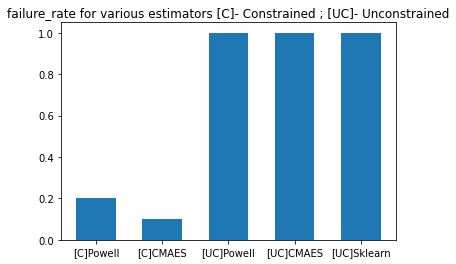

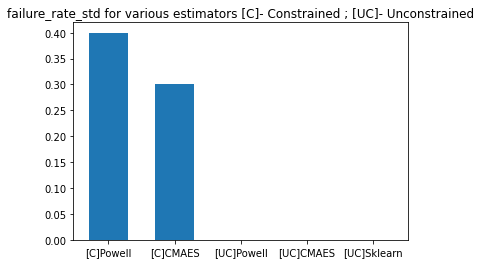

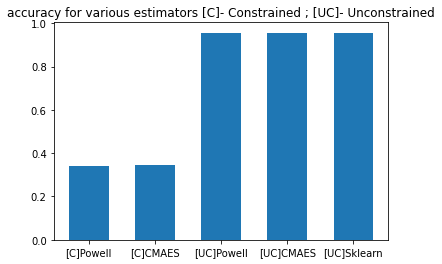

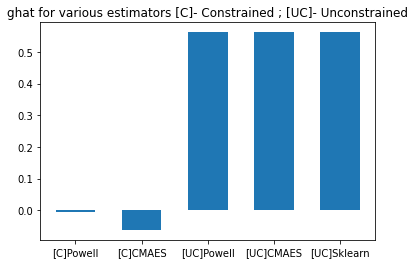

In [14]:
res_n = {
    'Const Powell': '[C]Powell',
    'Const CMA-ES': '[C]CMAES',
    'Unconst Powell': '[UC]Powell',
    'Unconst CMA-ES': '[UC]CMAES',
    'Unconst Scikit': '[UC]Sklearn'
} 
x = list(res.keys())
for k in res['Const Powell']:
    plt.bar(list(map(lambda x: res_n[x], x)), list(map(lambda x: res[x][k], res)), width=0.6)
    plt.title(f"{k} for various estimators [C]- Constrained ; [UC]- Unconstrained")
    plt.show()


## $\hat{g}$ result for the constrained optimizer

In [20]:
estimator_powell = LogisticRegressionSeldonianModel(X.to_numpy(), y.to_numpy().flatten(), g_hats=ghats,
                                               hard_barrier = False)
estimator_powell.fit()
print(f"\nAccuracy: {balanced_accuracy_score(y_t, estimator_powell.predict(X_t))}\n")

print(f"mean ghat value: {tpr_ab(X_t.to_numpy(), y_t.to_numpy().flatten(), estimator_powell.predict(X_t), delta=0.05, ub=False)}")

Optimization terminated successfully.
         Current function value: 979.174085
         Iterations: 2
         Function evaluations: 234
Optimization result: Optimization terminated successfully.

Accuracy: 0.3681846975899441

mean ghat value: 0.07373737373737377


## $\hat{g}$ for constrained estimator using CMAES

In [22]:
estimator_cmaes = SeldonianAlgorithmLogRegCMAES(X.to_numpy(), y.to_numpy().flatten(), g_hats=ghats, verbose=True,
                                            hard_barrier = False)
estimator_cmaes.fit()
print(f"\nAccuracy: {balanced_accuracy_score(y_t, estimator_cmaes.predict(X_t))}\n")

print(f"mean ghat value: {tpr_ab(X_t.to_numpy(), y_t.to_numpy().flatten(), estimator_cmaes.predict(X_t), delta=0.05, ub=False)}")

Max number of iters: 1890
max iterations: 16000.0
Current evaluation: 7464	 average loss:0.6829682759510991 

Stopping early after no change in 1896 iterations !!

Accuracy: 0.47624871057320406

mean ghat value: -0.09830563701531442


## $\hat{g}$ for unconstrained optimizer using `scipy.optimize` package

In [23]:
uc_estimator = LogisticRegressionSeldonianModel(X.to_numpy(), y.to_numpy().flatten(), g_hats=[]).fit(
        opt=op_method)
print(f"Accuracy: {balanced_accuracy_score(y_t, uc_estimator.predict(X_t))}\n")

print(f"mean ghat value: {tpr_ab(X_t.to_numpy(), y_t.to_numpy().flatten(), uc_estimator.predict(X_t), delta=0.05, ub=False)}")

Optimization terminated successfully.
         Current function value: 0.150800
         Iterations: 8
         Function evaluations: 374
Optimization result: Optimization terminated successfully.
Accuracy: 0.5211944446039283

mean ghat value: 0.5514173998044967


## $\hat{g}$ for unconstrained CMA-ES optimizer

In [25]:
uc_estimator_cmaes = LogisticRegressionCMAES(X.to_numpy(), y.to_numpy().flatten(), verbose=True)
uc_estimator_cmaes.fit()
print(f"Accuracy: {balanced_accuracy_score(y_t, uc_estimator_cmaes.predict(X_t))}\n")
print(f"mean ghat value: {tpr_ab(X_t.to_numpy(), y_t.to_numpy().flatten(), uc_estimator_cmaes.predict(X_t), delta=0.05, ub=False)}")

Max number of iters: 1890
max iterations: 16000.0
Current evaluation: 2616	 average loss:0.15566592365202658 

Stopping early after no change in 1896 iterations !!
Accuracy: 0.5213647733383857

mean ghat value: 0.5510915607689801


# Sklearn estimator

In [26]:
logreg_sk = LogisticRegression().fit(X.to_numpy(),y.to_numpy().flatten())
print(f"Accuracy: {balanced_accuracy_score(y_t, uc_estimator.predict(X_t))}\n")
print(f"mean ghat value: {tpr_ab(X_t.to_numpy(), y_t.to_numpy().flatten(), logreg_sk.predict(X_t), delta=0.05, ub=False)}")

Accuracy: 0.5211944446039283

mean ghat value: 0.5510915607689801
